# ga for knapsack

experiment with:

- population size
- generations count
- prob. crossover
- prob. mutation
- elite string (`HallOfFame`)
- selection
    - `selRoulette`
    - `selTournament`
    - `selRandom`
    - rank roulette, modify `selRoulette` input different fitness
- fitness variant
    - with correction
    - with penalization
- crossover operator
    - `cxOnePoint`
    - `cxTwoPoint`
    - `cxUniform`

In [1]:
import random
import numpy
from matplotlib import pyplot
from genetic_algorithm.tools import read_instances, read_solutions
from deap import algorithms, base, creator, tools

In [2]:
filename = 'data/knap_32.dat'
solution_filename = 'data/knap_32.sol.dat'

with open(filename) as f:
    instances = read_instances(f)
with open(solution_filename) as f:
    solutions = read_solutions(f)
len(instances), len(solutions)

(500, 500)

In [3]:
instance_index = 1
instance = instances[instance_index]
weights = instance['weights']
values = instance['values']
m = instance['m']
n = instance['n']
print('weights', weights)
print('values', values)
print('m', m)

solution = solutions[instance_index]
print('solution', solution['solution'])
print('solution_value', solution['solution_value'])
print('n', solution['n'])

weights [32, 59, 24, 51, 17, 58, 40, 28, 28, 46, 17, 72, 16, 75, 93, 81, 61, 82, 86, 34, 19, 93, 72, 96, 34, 48, 49, 29, 54, 81, 94, 72]
values [460, 194, 353, 243, 381, 164, 56, 149, 494, 364, 391, 361, 5, 346, 82, 87, 75, 178, 218, 450, 311, 431, 303, 111, 341, 105, 46, 317, 174, 317, 106, 77]
m 1356
solution [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0]
solution_value 7299
n 32


## individual and fitness

this will be same for all approaches

In [4]:
# fitness value is maximalized
creator.create('Fitness', base.Fitness, weights=(1,))
creator.create('Individual', list, fitness=creator.Fitness)

In [5]:
toolbox = base.Toolbox()
toolbox.register('attr_item', random.randint, 0, 1)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.attr_item, n)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('mate', tools.cxOnePoint)
toolbox.register('mutate', tools.mutFlipBit, indpb=0.05)
toolbox.register('select', tools.selRoulette)

In [6]:
def evaluate_constrain(individual, weights=weights, m=m):
    return sum(x * w for x, w in zip(individual, weights)) <= m

In [7]:
def plot_ga_progress(logbook):
    gs = logbook.select('gen')
    mins = logbook.select('min')
    avgs = logbook.select('avg')
    maxs = logbook.select('max')

    pyplot.scatter(gs, maxs, label='max')
    pyplot.scatter(gs, avgs, label='avg')
    pyplot.scatter(gs, mins, label='min')
    pyplot.xlabel('generation')
    pyplot.ylabel('fitness')
    pyplot.legend()

### genetic algorithm

In [8]:
def genetic_algorithm(population, toolbox, ngen, cxpb, mutpb, elitism):
    # stats
    stats = tools.Statistics(lambda individual: individual.fitness.values)
    stats.register('avg', numpy.mean)
    stats.register('min', numpy.min)
    stats.register('max', numpy.max)
    # logbook
    logbook = tools.Logbook()
    logbook.header = ['gen', 'min', 'avg', 'max']
    
    # evaluate the entire population
    fitnesses = map(toolbox.evaluate, population)
    for individual, fitness in zip(population, fitnesses):
        individual.fitness.values = fitness
        
    # halloffame
    halloffame = tools.HallOfFame(maxsize=elitism)
    halloffame.update(population)
        
    # begin the evolution
    for g in range(1, ngen + 1):    
        # select the next generation individuals
        offspring = toolbox.select(population, k=len(population) - len(halloffame))
        # clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # apply crossover and mutation on the offspring
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # evaluate the individuals with an invalid fitness
        invalids = [individual for individual in offspring if not individual.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalids)
        for individual, fitness in zip(invalids, fitnesses):
            individual.fitness.values = fitness

        # replace the current population by the offspring
        population[:] = offspring + halloffame.items

        halloffame.update(population)

        # append the current generation statistics to the logbook
        record = stats.compile(population)
        logbook.record(gen=g, **record)
        print(logbook.stream)
    
    return population, logbook, halloffame

## penalization

gen	min 	avg    	max 
1  	2207	3919.83	5954
2  	2130	4060.67	6116
3  	2130	4166.51	6116
4  	2283	4348.58	6116
5  	2283	4445.94	6116
6  	2378	4639.79	6443
7  	2975	4746.75	6443
8  	-1452	4833.22	6465
9  	3197 	4940.76	6465
10 	3710 	5160.55	6465
11 	-1359	5211.62	6571
12 	3637 	5502.23	6867
13 	-1436	5525.26	6973
14 	-1411	5690.12	6973
15 	-1432	5710.91	6973
16 	-1560	5613.67	7015
17 	-1416	5764.75	7015
18 	4551 	5862.84	7015
19 	-1375	5836.7 	7015
20 	-1394	5926.51	7015
21 	-1365	6000.5 	7015
22 	-1442	5700.08	7015
23 	-1446	5957.81	7015
24 	-1515	5813.01	7055
25 	-1446	5901.36	7055
26 	-1446	6080.99	7055
27 	-1361	6171.32	7069
28 	5029 	6258.46	7069
29 	5218 	6378.41	7069
30 	-1446	6364.22	7069
31 	-1405	6187.41	7069
32 	5503 	6517.26	7069
33 	-1410	6370.13	7069
34 	-1406	6341.34	7069
35 	-1390	6146.96	7069
36 	-1362	6190.26	7069
37 	-1362	6387.85	7069
38 	-1431	5983.07	7141
39 	-1455	5938.34	7141
40 	-1381	6073.55	7141
41 	-1365	6349.85	7141
42 	-1372	6327.76	7141
43 	-1403	6138.36	7

(7299, (7146.0,))

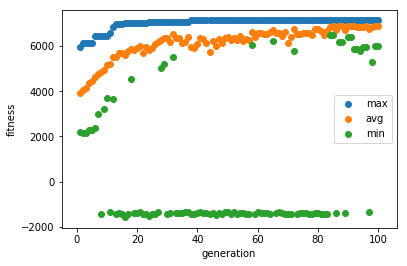

In [9]:
def evaluate_penalization(individual, weights=weights, values=values, m=m):
    total_weight = 0
    total_value = 0
    for x, weight, value in zip(individual, weights, values):
        total_weight += x * weight
        total_value += x * value
    if total_weight > m:
        return -total_weight,
    return total_value,

toolbox.register('evaluate', evaluate_penalization, weights=weights, values=values, m=m)

N_POP = 100
N_GEN = 100
CXPB = 0.6
MUTPB = 0.01

population = toolbox.population(n=N_POP)
population, logbook, halloffame = genetic_algorithm(
    population, toolbox, ngen=N_GEN, cxpb=CXPB, mutpb=MUTPB, elitism=1
)

plot_ga_progress(logbook)

best = halloffame.items[0]
solution['solution_value'], halloffame[0].fitness.values

## correct indivuduals

gen	min 	avg    	max 
1  	2171	3998.31	6156
2  	2499	4253.84	6156
3  	2437	4526.8 	6156
4  	2437	4595.15	6156
5  	2503	4679.41	6156
6  	3205	4869.99	6156
7  	2861	4892.64	6413
8  	3370	5008.12	6428
9  	3605	5114.5 	6428
10 	3443	5210.79	6774
11 	3782	5421.77	6774
12 	3782	5628.89	6774
13 	3782	5772.69	6931
14 	4268	5852.99	6931
15 	4383	5937.79	6931
16 	3645	5899.11	6931
17 	4269	5997.93	6931
18 	4631	6014.66	6931
19 	4631	6032.68	7083
20 	4631	6175.62	7083
21 	5053	6277.5 	7088
22 	4985	6200.57	7088
23 	4985	6193.85	7088
24 	4573	6227.89	7088
25 	4573	6332.77	7088
26 	4796	6425.17	7088
27 	4796	6477.28	7136
28 	4796	6497   	7136
29 	5672	6473.14	7136
30 	5630	6519.49	7136
31 	5630	6526.36	7136
32 	5570	6544.31	7147
33 	5373	6540.62	7188
34 	5620	6518.78	7188
35 	5626	6531.8 	7188
36 	5626	6546.45	7188
37 	5694	6566.12	7188
38 	5791	6606.71	7188
39 	5388	6601.9 	7188
40 	5683	6603.68	7188
41 	5676	6605.17	7188
42 	5869	6622.86	7188
43 	5869	6648.54	7188
44 	5973	6682.98	7250
45 	5767	6

(7299, (7255.0,))

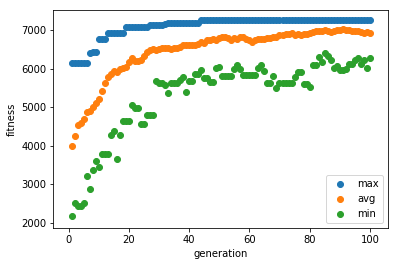

In [10]:
def correct_individual(individual, weights=weights, m=m):
    while evaluate_constrain(individual, weights, m) is False:
        indexes = [index for index, x in enumerate(individual) if x]
        individual[random.choice(indexes)] = 0
    return individual

def evaluate_correction(individual, values=values):
    individual = correct_individual(individual)
    total_value = 0
    for x, value in zip(individual, values):
        total_value += x * value
    return total_value,

toolbox.register('evaluate', evaluate_correction, values=values)

N_POP = 100
N_GEN = 100
CXPB = 0.6
MUTPB = 0.01

population = toolbox.population(n=N_POP)
population, logbook, halloffame = genetic_algorithm(
    population, toolbox, ngen=N_GEN, cxpb=CXPB, mutpb=MUTPB, elitism=1
)

plot_ga_progress(logbook)

best = halloffame.items[0]
solution['solution_value'], halloffame[0].fitness.values